# Cours #2b -  Réseaux de neurones sur graphes pour capturer les dépendances dans des données structurées en graphe

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/geo-stack/cours_ml_envirocan/blob/main/02b_gnn_raschka_example.ipynb)

> **Note — Source de l'exemple :** cet exercice est tiré du livre *Machine Learning with PyTorch and Scikit-Learn* (Sebastian Raschka et al.), **chapitre 18**.  
> Code et ressources associés : https://github.com/rasbt/machine-learning-book

## 1. Configuration de l'environnement

In [1]:
import sys
from packaging import version

import torch
import torch.nn.functional as F
import torch.nn as nn

!pip install torch_geometric -q

from torch_geometric.loader import DataLoader
from torch_geometric.nn import NNConv, global_add_pool

import numpy as np

from IPython.display import Image
%matplotlib inline

print('Environnement configuré avec succès!')


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 32.7 MB/s eta 0:00:00
Environnement configuré avec succès!


## 2. Téléchargement et chargement du jeu de données


Le jeu de données *QM9* contient plus de 130k petites molécules organiques, étiquetées avec plusieurs propriétés géométriques, énergétiques, électroniques et thermodynamiques.

*QM9* est un jeu de données de référence couramment utilisé pour développer des méthodes visant à prédire les relations entre la structure chimique et les propriétés associées, ainsi que des méthodes hybrides combinant la mécanique quantique et l’apprentissage automatique.

Pour plus d’informations sur ce jeu de données, allez à l’adresse suivante : http://quantum-machine.org/datasets/.

In [2]:
from torch_geometric.datasets import QM9

# Télécharge (si besoin) et charge le dataset dans le dossier courant.

dset = QM9('.')
len(dset)

Extracting ./raw/qm9_v3.zip
Processing...
Using a pre-processed version of the dataset. Please install 'rdkit' to alternatively process the raw data.
Done!


130831

## 3. Représentation "graphe" des molécules (idée clé)

Dans *PyTorch Geometric*, chaque molécule est représentée comme un *graphe* :
- nœuds : atomes
- arêtes : liaisons chimiques
- attributs : caractéristiques (*features*) des atomes et des liaisons, ainsi que les propriétés cibles à prédire

Par exemple, pour la première molécule du dataset (`data = dset[0]`), on obtient :

`Data(x=[5, 11], edge_index=[2, 8], edge_attr=[8, 4], y=[1, 19], pos=[5, 3], ..., z=[5])`

- `x=[5, 11]` signifie que la molécule contient 5 nœuds (5 atomes) et que chaque atome est décrit par 11 caractéristiques.
- `edge_index=[2, 8]` indique qu'il y a 8 arêtes dans le graphe. Le `2` correspond aux deux lignes (source → destination). À noter que ces arêtes sont généralement orientées dans PyG: une liaison chimique non orientée est souvent représentée par deux arêtes (i→j et j→i). Ainsi, 8 arêtes correspondent souvent à ~4 liaisons.
- `edge_attr=[8, 4]` signifie que chaque arête possède 4 attributs (par ex. des informations sur le type de liaison).
- `y=[1, 19]` signifie que cette molécule est associée à 19 propriétés cibles (labels) dans QM9, comme par exemple la polarisabilité isotrope.
- `z=[5]` contient les numéros atomiques des 5 atomes (un numéro atomique par nœud).
- `pos=[5, 3]` contient les coordonnées 3D (x, y, z) des 5 atomes.

In [3]:
data = dset[0]

print("Résumé de la première molécule (objet PyG Data) :")
print(data)
print()
print("Détails :")
print("nombre de nœuds (atomes) :", data.num_nodes)
print("nombre d'arêtes (orientées) :", data.edge_index.size(1))
print("nombre approximatif de liaisons (non orientées) :", data.edge_index.size(1) // 2)
print("numéros atomiques z :", data.z.tolist())
print()
print(f"Chaque molécule du jeu de données QM9 est associée à {data.y.size(-1)} propriétés cibles (valeurs à prédire).")

Résumé de la première molécule (objet PyG Data) :
Data(x=[5, 11], edge_index=[2, 8], edge_attr=[8, 4], y=[1, 19], pos=[5, 3], idx=[1], name='gdb_1', z=[5])

Détails :
nombre de nœuds (atomes) : 5
nombre d'arêtes (orientées) : 8
nombre approximatif de liaisons (non orientées) : 4
numéros atomiques z : [6, 1, 1, 1, 1]

Chaque molécule du jeu de données QM9 est associée à 19 propriétés cibles (valeurs à prédire).


## 4. Définition du modèle GNN (ExampleNet)

Dans cette cellule, on définit un réseau de neurones sur graphes (*Graph Neural Network*, GNN) qui prendra en entrée une molécule représentée sous forme de graphe (atomes = nœuds, liaisons = arêtes) et produira en sortie une prédiction au niveau de la molécule (une valeur numérique).

Le modèle utilise ici des couches *NNConv* (convolution sur graphes qui tient compte des attributs d'arêtes, donc des liaisons chimiques) pour mettre à jour les représentations des atomes. Ensuite, on applique un *pooling global* (`global_add_pool`) pour agréger l'information de tous les atomes en un seul vecteur représentant la molécule, puis un petit réseau dense (couches `Linear`) pour obtenir la prédiction finale.

In [4]:
class ExampleNet(torch.nn.Module):
    def __init__(self, num_node_features, num_edge_features):
        super().__init__()
        conv1_net = nn.Sequential(nn.Linear(num_edge_features, 32),
                                  nn.ReLU(),
                                  nn.Linear(32, num_node_features * 32))
        conv2_net = nn.Sequential(nn.Linear(num_edge_features,32),
                                  nn.ReLU(),
                                  nn.Linear(32, 32 * 16))
        self.conv1 = NNConv(num_node_features, 32, conv1_net)
        self.conv2 = NNConv(32, 16, conv2_net)
        self.fc_1 = nn.Linear(16, 32)
        self.out = nn.Linear(32, 1)

    def forward(self, data):
        batch, x, edge_index, edge_attr=data.batch, data.x, data.edge_index, data.edge_attr
        x = F.relu(self.conv1(x, edge_index, edge_attr))
        x = F.relu(self.conv2(x, edge_index, edge_attr))
        x = global_add_pool(x, batch)
        x = F.relu(self.fc_1(x))
        output = self.out(x)
        return output

## 5. Séparation du dataset et création des DataLoaders

Avant d'entraîner le modèle, on divise le jeu de données en trois sous-ensembles: entraînement, validation et test.

Ensuite, on crée des *DataLoaders* qui permettent de parcourir ces ensembles par *mini-lots (batches)* de molécules. Le paramètre `shuffle=True` mélange l'ordre des molécules à chaque époque, ce qui aide généralement l'entraînement.

In [5]:
from torch.utils.data import random_split

train_set, valid_set, test_set = random_split(dset, [110000, 10831, 10000])

trainloader = DataLoader(train_set, batch_size=32, shuffle=True)
validloader = DataLoader(valid_set, batch_size=32, shuffle=True)
testloader = DataLoader(test_set, batch_size=32, shuffle=True)

## 6. Initialisation du modèle, choix de la cible et préparation de l'entraînement

Dans cette cellule, on prépare tout ce qui est nécessaire pour l'entraînement :

- On précise le nombre de caractéristiques utilisées par QM9 pour les nœuds (atomes) et les arêtes (liaisons), afin de créer le modèle `ExampleNet` avec les bonnes dimensions d'entrée.
- On choisit l'optimiseur (`Adam`) et le taux d'apprentissage (*learning rate*), qui déterminent comment les paramètres du réseau seront ajustés pendant l'entraînement.
- On sélectionne la propriété cible à prédire via `target_idx`. Le dataset QM9 fournit 19 propriétés; ici on n'en prédit qu'une seule (la polarisabilité) pour simplifier l'exemple.
- Enfin, on détecte si un GPU est disponible et on déplace le modèle sur le bon appareil (`CPU` ou `CUDA`) avec `net.to(device)`.

In [6]:
qm9_node_feats, qm9_edge_feats = 11, 4
epochs = 4
net = ExampleNet(qm9_node_feats, qm9_edge_feats)

optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
epochs = 4
target_idx = 1 # index position of the polarizability label

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)

ExampleNet(
  (conv1): NNConv(11, 32, aggr=add, nn=Sequential(
    (0): Linear(in_features=4, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=352, bias=True)
  ))
  (conv2): NNConv(32, 16, aggr=add, nn=Sequential(
    (0): Linear(in_features=4, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=512, bias=True)
  ))
  (fc_1): Linear(in_features=16, out_features=32, bias=True)
  (out): Linear(in_features=32, out_features=1, bias=True)
)

## 7. Entraînement du modèle et validation

Dans cette cellule, on entraîne le modèle pendant `epochs` époques et on suit, à chaque époque, la perte moyenne sur l'ensemble d'entraînement et sur l'ensemble de validation.

On s'arrête après 4 époques parce que le dataset QM9 est volumineux et l'entraînement peut être long sur CPU. Sur ces premières époques, on observe généralement une diminution des pertes d'entraînement et de validation. En prolongeant l'entraînement, la performance pourrait continuer à s'améliorer.

In [7]:
for total_epochs in range(epochs):

    epoch_loss = 0
    total_graphs = 0
    net.train()
    for batch in trainloader:
        batch.to(device)
        optimizer.zero_grad()
        output = net(batch)
        loss = F.mse_loss(output, batch.y[:, target_idx].unsqueeze(1))
        loss.backward()
        epoch_loss += loss.item()
        total_graphs += batch.num_graphs
        optimizer.step()

    train_avg_loss = epoch_loss / total_graphs
    val_loss = 0
    total_graphs = 0
    net.eval()
    for batch in validloader:
        batch.to(device)
        output = net(batch)
        loss = F.mse_loss(output,batch.y[:, target_idx].unsqueeze(1))
        val_loss += loss.item()
        total_graphs += batch.num_graphs
    val_avg_loss = val_loss / total_graphs


    print(f"Epochs: {total_epochs} | epoch avg. loss: {train_avg_loss:.2f} | validation avg. loss: {val_avg_loss:.2f}")

Epochs: 0 | epoch avg. loss: 0.39 | validation avg. loss: 0.12
Epochs: 1 | epoch avg. loss: 0.13 | validation avg. loss: 0.12
Epochs: 2 | epoch avg. loss: 0.11 | validation avg. loss: 0.08
Epochs: 3 | epoch avg. loss: 0.10 | validation avg. loss: 0.07


## 8. Prédictions sur l’ensemble de test

Après l'entraînement, on passe le modèle en mode évaluation (`net.eval()`) et on l'applique aux molécules de l'ensemble de test. On récupère d'un côté les prédictions du modèle et de l'autre les valeurs réelles (la propriété QM9 choisie via `target_idx`). Les résultats sont ensuite concaténés pour obtenir deux tableaux `predictions` et `real` qui sont ensuite comparés avec un graphique.

Text(0.5, 0, 'Isotropic polarizability')

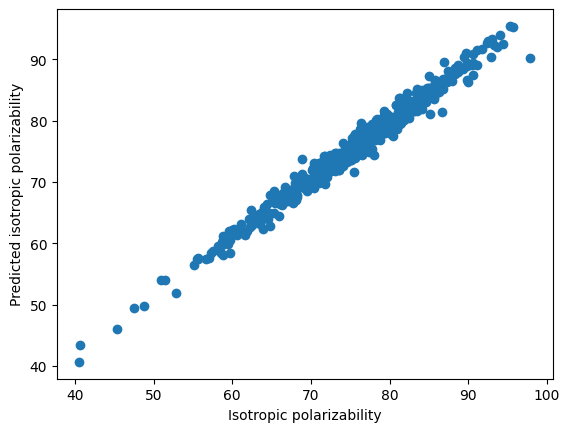

In [8]:
net.eval()
predictions = []
real = []

for batch in testloader:

    output = net(batch.to(device))
    predictions.append(output.detach().cpu().numpy())
    real.append(batch.y[:, target_idx].detach().cpu().numpy())

predictions = np.concatenate(predictions)
real = np.concatenate(real)

import matplotlib.pyplot as plt

fix, ax = plt.subplots()
ax.scatter(real[:500],predictions[:500])
ax.set_ylabel('Predicted isotropic polarizability')
ax.set_xlabel('Isotropic polarizability')